In [27]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from tqdm import tqdm
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve

import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nopep8
import tensorflow as tf

import matplotlib.pyplot as plt
import optuna

sys.path.append(os.path.dirname(os.getcwd()))
from src.custom_utils import get_secret, get_db_url, StudyVisualizer

## Hydrda

In [10]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='tf_keras_notebook')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

## S3

In [3]:
s3 = boto3.client('s3')

train_val_path = {'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
                  'val': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val'}
train_val_path

{'train': 's3://yang-ml-sagemaker/census-income-classification/input-data/train',
 'val': 's3://yang-ml-sagemaker/census-income-classification/input-data/val'}

## SageMaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()

## Database

In [ ]:
cf = boto3.client('cloudformation')
outputs = cf.describe_stacks(StackName=config.stack_name)['Stacks'][0]['Outputs']

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'ClusterEndpoint'][0].split(':')[0]
db_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DatabaseName'][0]
secret_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DBSecretArn'][0].split(':')[-1].split('-')[0]

subnets = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'PrivateSubnets'][0].split(',')
security_group_ids = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'SageMakerSecurityGroup'][0].split(',')

## Tensorflow

Test locally:

In [ ]:
test_study_name = 'test-study'

test_estimator = TensorFlow(
    entry_point=config['tf_keras']['entry_point'],
    source_dir=config['src_dir_path'],
    role=role,
    py_version=config['tf_keras']['py_version'],
    framework_version=config['tf_keras']['framework_version'],
    model_dir=config['model_dir'],
    output_path=config['output_path'],
    code_location=config['code_location'],
    instance_type='local',
    instance_count=config['tf_keras']['instance_count'],
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'study_name': test_study_name,
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'n_trials': 2,
        'test_mode': 1,
        'multi_gpu': 0,
        'epsilon': 1e-16,
        'early_stopping_patience': 2,
        'verbose': 0
    }
)

test_estimator

In [13]:
!sudo rm -rf /tmp/tmp*

In [8]:
test_estimator.fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-07-16-09-06-59-898
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-or4zt:
    command: train
    container_name: n059ttwqnn-algo-1-or4zt
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.12.0-cpu-py310
    networks:
      sagemaker-local:
        aliases:
        - algo-1-or4zt
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpr48k9xe4/algo-1-or4zt/input:/opt/ml/input
    

Creating n059ttwqnn-algo-1-or4zt ... 
Creating n059ttwqnn-algo-1-or4zt ... done
Attaching to n059ttwqnn-algo-1-or4zt
n059ttwqnn-algo-1-or4zt | 2023-07-16 09:07:02.618928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
n059ttwqnn-algo-1-or4zt | To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
n059ttwqnn-algo-1-or4zt | 2023-07-16 09:07:05,302 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
n059ttwqnn-algo-1-or4zt | 2023-07-16 09:07:05,304 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
n059ttwqnn-algo-1-or4zt | 2023-07-16 09:07:05,304 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
n059ttwqnn-algo-1-or4zt | 2023-07-16 09:07:05,314 sagemaker-training-toolkit INFO     instance_groups e

INFO:root:creating /tmp/tmpr48k9xe4/artifacts/output/data
INFO:root:copying /tmp/tmpr48k9xe4/algo-1-or4zt/output/success -> /tmp/tmpr48k9xe4/artifacts/output
INFO:root:creating /tmp/tmpr48k9xe4/artifacts/model/00000000
INFO:root:creating /tmp/tmpr48k9xe4/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmpr48k9xe4/model/00000000/variables/variables.data-00000-of-00001 -> /tmp/tmpr48k9xe4/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmpr48k9xe4/model/00000000/variables/variables.index -> /tmp/tmpr48k9xe4/artifacts/model/00000000/variables
INFO:root:creating /tmp/tmpr48k9xe4/artifacts/model/00000000/assets
INFO:root:copying /tmp/tmpr48k9xe4/model/00000000/fingerprint.pb -> /tmp/tmpr48k9xe4/artifacts/model/00000000
INFO:root:copying /tmp/tmpr48k9xe4/model/00000000/saved_model.pb -> /tmp/tmpr48k9xe4/artifacts/model/00000000
INFO:root:copying /tmp/tmpr48k9xe4/model/00000000/keras_metadata.pb -> /tmp/tmpr48k9xe4/artifacts/model/00000000


n059ttwqnn-algo-1-or4zt exited with code 0
Aborting on container exit...
===== Job Complete =====


In [11]:
db_url = get_db_url(host=host, db_name=db_name, db_secret=secret_name, region_name=sagemaker_session._region_name)

optuna.study.delete_study(study_name=test_study_name, storage=db_url)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Re-instantiate estimator:

In [18]:
tf_estimator = TensorFlow(
    # Entry point
    entry_point=config['tf_keras']['entry_point'],
    source_dir=config['src_dir_path'],
    py_version=config['tf_keras']['py_version'],
    framework_version=config['tf_keras']['framework_version'],
    # Sagemaker
    role=role,
    instance_type=config['tf_keras']['instance_type'],
    instance_count=config['tf_keras']['instance_count'],
    model_dir=config['model_dir'],
    output_path=config['output_path'],
    volume_size=config['volume_size'],
    base_job_name=config['tf_keras']['base_job_name'],
    sagemaker_session=sagemaker_session,
    # Spot traning
    max_run=config['max_run'],
    max_wait=config['max_run'], # Equal or greater than max_run
    max_retry_attempts=config['max_retry_attempts'],
    use_spot_instances=config['use_spot_instances'],
    checkpoint_s3_uri=os.path.join(config['checkpoint_s3_uri'], 'tf_keras'),
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'study_name': config['tf_keras']['study_name'],
        'n_trials': 10,
        'test_mode': 0,
        'multi_gpu': 1,
        'epsilon': 1e-16,
        'early_stopping_patience': 3,
        'verbose': 2
    }
)

tf_estimator

### Hyperparameter Tuning

In [19]:
tf_estimator.fit(train_val_path)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tf-keras-training-2023-07-16-19-57-41-992


2023-07-16 19:57:42 Starting - Starting the training job......
2023-07-16 19:58:19 Starting - Preparing the instances for training......
2023-07-16 19:59:33 Downloading - Downloading input data...
2023-07-16 19:59:53 Training - Downloading the training image........................
2023-07-16 20:03:59 Training - Training image download completed. Training in progress....2023-07-16 20:04:30,250 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-07-16 20:04:30,285 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-16 20:04:30,652 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/usr/local/bin/python3.10 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 31.7 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 10.1 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 16.1 MB/s eta 0:00:00

### Study Object

In [22]:
study = optuna.study.load_study(study_name=config['tf_keras']['study_name'], storage=db_url)
study

In [24]:
hpo_visualizer = StudyVisualizer(study=study)
hpo_visualizer

Optimization history:

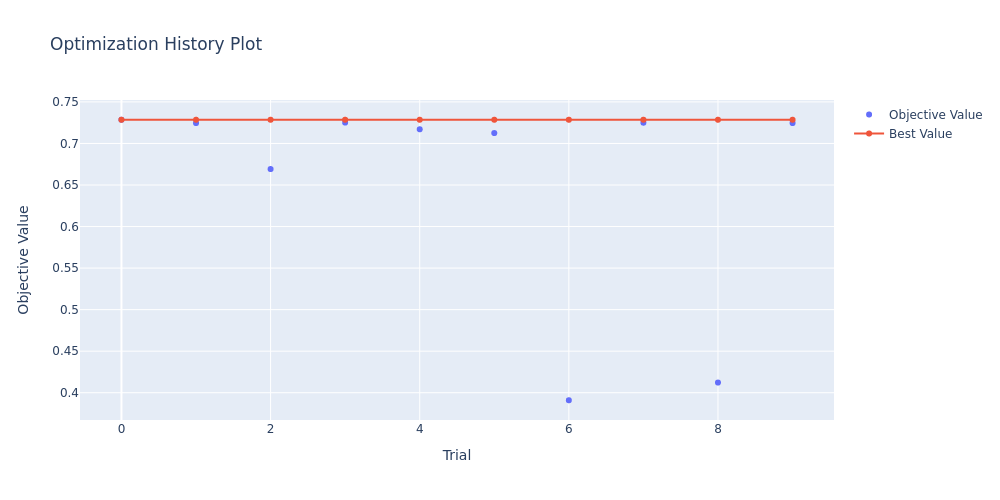

In [25]:
hpo_visualizer.plot_optimization_history(figsize=(1000, 500))

Parallel coordinates:

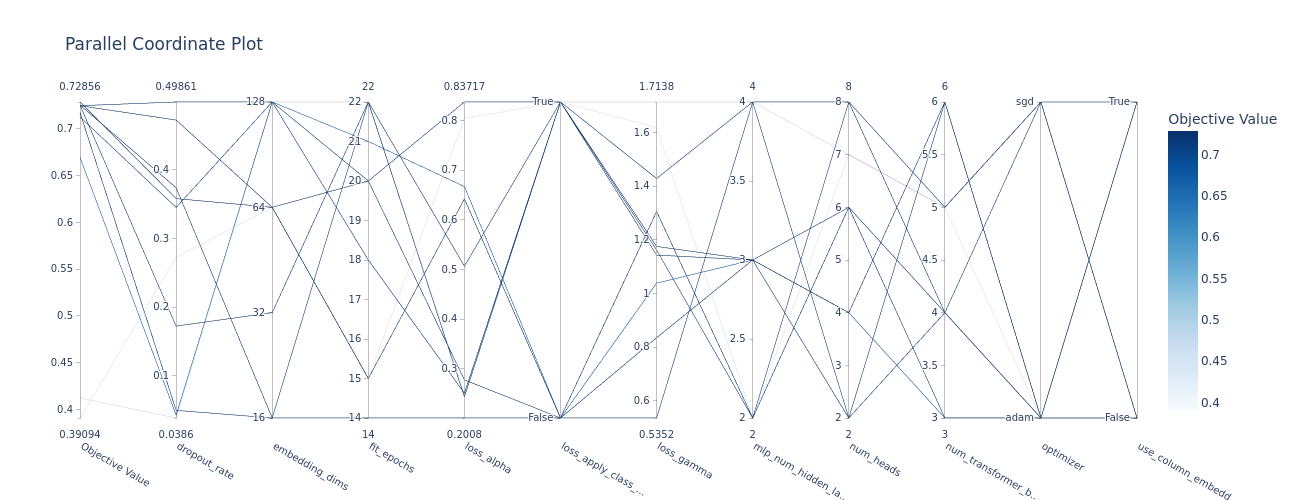

In [26]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=['num_transformer_blocks', 'num_heads', 'embedding_dims', 'mlp_num_hidden_layers', 'dropout_rate', 'use_column_embedding', 
            'optimizer', 'loss_apply_class_balancing', 'loss_alpha', 'loss_gamma', 'fit_epochs']
)

Hyperparameter importance:

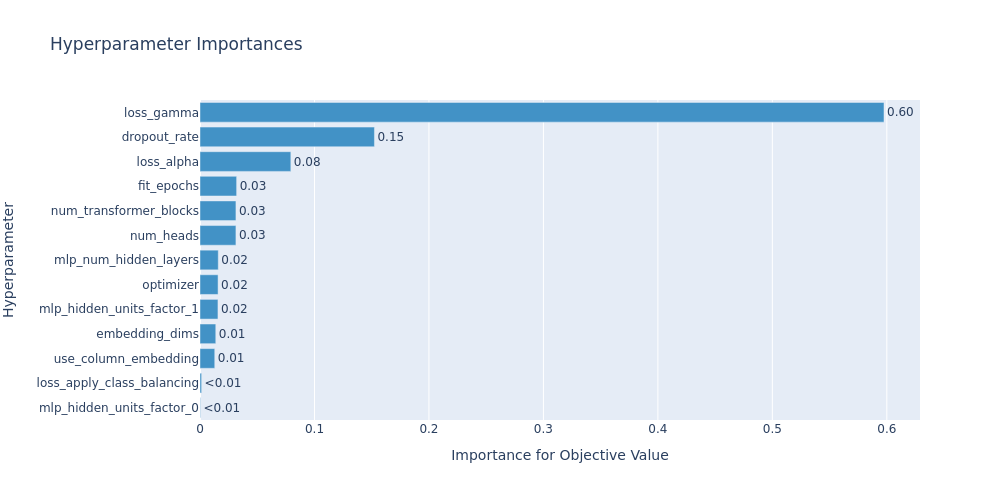

In [27]:
hpo_visualizer.plot_param_importances(figsize=(1000, 500))

### TensorBoard

In [38]:
tensorboard_log_dir = f's3://{config["s3_bucket"]}/{config["s3_key"]}/tensorboard_logs/{study.best_trial.user_attrs["job_name"]}_{study.best_trial.number}'

!tensorboard --logdir $tensorboard_log_dir --host localhost --port 6006

2023-07-16 22:19:26.484506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Inference on Test Set

In [23]:
test_data = pd.read_csv(f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test/test.csv', names=config['csv_header'])
test_data.shape

(16281, 15)

In [24]:
# Split into weight column, target, and features
weights = test_data['fnlwgt'].values
target = test_data['income_bracket'].map({' <=50K': 0, ' >50K': 1}).values
features = test_data.drop(['fnlwgt', 'income_bracket'], axis=1).values

In [7]:
features

array([[25, ' Private', ' 11th', ..., 0.0, 40.0, ' United-States'],
       [38, ' Private', ' HS-grad', ..., 0.0, 50.0, ' United-States'],
       [28, ' Local-gov', ' Assoc-acdm', ..., 0.0, 40.0,
        ' United-States'],
       ...,
       [38, ' Private', ' Bachelors', ..., 0.0, 50.0, ' United-States'],
       [44, ' Private', ' Bachelors', ..., 0.0, 40.0, ' United-States'],
       [35, ' Self-emp-inc', ' Bachelors', ..., 0.0, 60.0,
        ' United-States']], dtype=object)

### Deploy Best Model

In [11]:
best_model_data = os.path.join(tf_estimator.output_path, study.best_trial.user_attrs['job_name'], 'output/model.tar.gz')

best_model = Model(
    image_uri=config['tf_keras']['serving_image_uri'],
    model_data=best_model_data,
    role=role,
    name=config['tf_keras']['model_name'],
    sagemaker_session=sagemaker_session
)

best_model.deploy(
    initial_instance_count=config['tf_keras']['instance_count'],
    instance_type=config['tf_keras']['inference_instance_type'],
    endpoint_name=config['tf_keras']['endpoint_name'] + '-v1'
)

predictor = Predictor(
    endpoint_name=best_model.endpoint_name,
    sagemaker_session=sagemaker_session
)

----!

In [15]:
# Define the batch size (number of samples to be sent for inference at once)
batch_size = 1000

# Generate predictions in batches
num_instances = features.shape[0]
num_batches = (num_instances + batch_size - 1) // batch_size

predicted_labels = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_instances)
    batch = features[start_idx:end_idx]
    
    # Bytes
    prediction_bytes = predictor.predict(str(batch.tolist()))
    # Deserialize byes to list of lists (one list per sample)
    prediction_lists = json.loads(prediction_bytes)
    
    # Append the predicted probabilities matrix to the container list
    predicted_labels.append(prediction_lists)

    # Wait 2 seconds before requesting inference predictions for the next batch
    time.sleep(2)

# Concatenate the predicted matrices from all batches
y_pred_positive = np.concatenate(predicted_labels, axis=0).flatten()

y_pred_positive

100%|██████████| 17/17 [00:38<00:00,  2.27s/it]


array([0.01616974, 0.09192939, 0.39172667, ..., 0.64739335, 0.19788095,
       0.76747239])

Evaluation:

In [25]:
print(classification_report(target, (y_pred_positive > 0.5).astype(np.int8)))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12435
           1       0.73      0.55      0.63      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.74      0.76     16281
weighted avg       0.84      0.85      0.84     16281



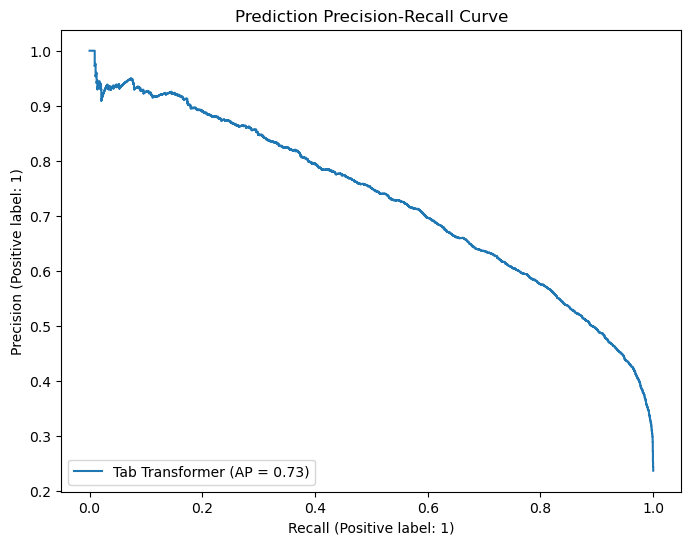

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(target, y_pred_positive, name='Tab Transformer', ax=ax)
plt.title('Prediction Precision-Recall Curve')
plt.show();

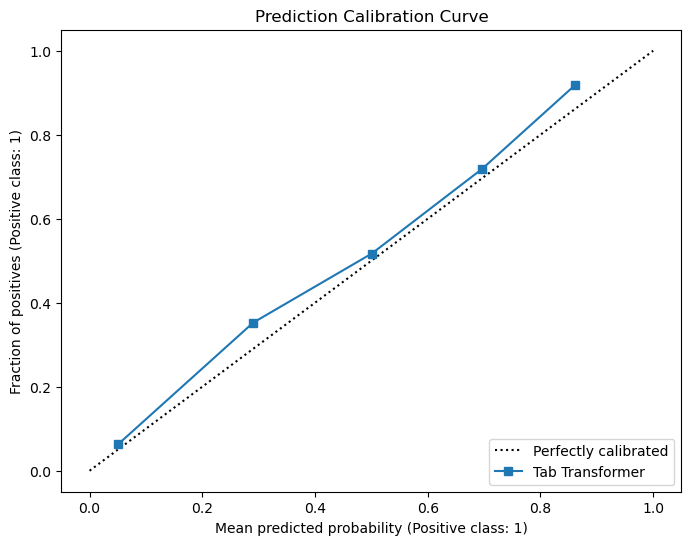

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
CalibrationDisplay.from_predictions(target, y_pred_positive, name='Tab Transformer', ax=ax)
plt.title('Prediction Calibration Curve')
plt.show();

Because the predictions (logits) are transformed with `tf.nn.sigmoid`, the classifier is well-calibrated. A well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to, say, 0.8, approximately 80% actually belong to the positive class.

In [31]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': '56a5cd99-9b5a-40d6-8a71-4f3683adaf92',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '56a5cd99-9b5a-40d6-8a71-4f3683adaf92',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 17 Jul 2023 06:56:11 GMT'},
  'RetryAttempts': 0}}

In [33]:
sm_boto3.close()